In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import dask.array as da

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(18, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:

model = Model()
model.load_state_dict(torch.load('../../../model/aminer/model.pth'))

<All keys matched successfully>

In [5]:
model.eval()

Model(
  (fc1): Linear(in_features=18, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
DATAPATH = "../../../data/DBLP/"
START_YEAR = 2000
END_YEAR = 2020
YEAR_STD = END_YEAR - START_YEAR

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print("GPUを使っているかどうか？    {}".format(torch.cuda.is_available()))

GPUを使っているかどうか？    True


In [11]:
test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")

In [13]:
N = test_x.shape[0]
print("データサイズ: {}, {}".format(N, N*N))

データサイズ: 1233, 1520289


In [14]:
test_x, test_y = test_x.reshape(N*N,18), test_y.reshape(N*N,1)

In [15]:
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)

In [16]:
test_dataset = torch.utils.data.TensorDataset(test_x,test_y)

In [17]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
model.to(device)

Model(
  (fc1): Linear(in_features=18, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
actual_labels, pred_labels = np.empty(0), np.empty(0)
score = 0
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    labels, outputs = labels.reshape(-1), outputs.reshape(-1)
    actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
    pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])

  0%|          | 0/47510 [00:00<?, ?it/s]

In [22]:
print(pearsonr(actual_labels, pred_labels))

(0.343553399168018, 0.0)


In [28]:
x = list(np.random.randint(0, len(actual_labels)-1, 10000))
al = actual_labels[x]
pl = pred_labels[x]

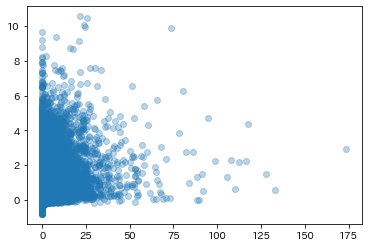

In [30]:
plt.scatter(actual_labels, pred_labels, alpha=0.3)